### Import Library & Data

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

In [3]:
df = pd.read_csv('Data/PMobX_NPS_Analysis.csv')
df = df.dropna(axis=1, how='all')
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment App Related               Key Theme  \
0     Negative         Yes  Features and Promotion   
1     Negative         Yes             Reliability   
2     Negative         Yes     UI/UX and Usability   
3     Negative         Yes     UI/UX and Usability   
4     Negative         Yes          Fees and Rates   
...        ...         ...                     ...   
4012  Negative          No                Services   
4013  Negative         Yes                Services   
4014   Neutral          No                 General   
4015  Negative         Yes     UI/UX and Usability   
4016  Negative          No                Services   

                       Specific Themes  
0                     Missing Features  
1                  Failed Transactions  
2                        Complex UI/UX  
3     Application is not user-friendly  
4              Limitations on transfer  
...                                ...  
4012                  Language barrier  
4013                  Transfer failure  
4014                  Neutral feedback  
4015          App accessibility issues  
4016                Lack of facilities  

[4017 rows x 6 columns]

### 1. Cleaning Data

In [4]:
df = df[['Date', 'Feedback', 'Sentiment','Key Theme']]
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4012  Negative                Services  
4013  Negative                Services  
4014   Neutral                 General  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[4017 rows x 4 columns]

In [5]:
df.shape

(4017, 4)

In [6]:
# remove duplicates
df = df.drop_duplicates(subset='Feedback')

# remove empty rows
df = df.dropna()

df.shape

(3006, 4)

In [7]:
# Cleaning data
def clean_Feedback_data(text):
    # Remove mentions (e.g., @username)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags (e.g., #keyword)
    text = re.sub(r'#\w+', '', text)
    # Remove retweet markers (e.g., RT at the beginning of retweeted messages)
    text = re.sub(r'RT[\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    # Remove numbers (e.g., transaction IDs or dates)
    text = re.sub(r'\d+', '', text)
    # Remove non-alphanumeric characters (keeping only letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    # Remove "-nya" suffix from words (both combined and separated forms)
    text = re.sub(r'\b(\w+?)\s?nya\b', r'\1', text)
    # Remove extra characters (e.g., "ssseeeppiiii" -> "sepi")
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['Feedback'] = df['Feedback'].apply(clean_Feedback_data)

In [8]:
# lower case
df['Feedback'] = df['Feedback'].str.lower()

In [9]:
df.head(10)

Date                                           Feedback  \
0  7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1  7/14/2024 19:46                                transfer gagal mulu   
2  7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3  7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4   7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
5   7/15/2024 7:53  antrian lama bgt saat di bank harap dipercepat...   
6   7/15/2024 9:16                                         w paylorld   
7  7/15/2024 10:16                                              delay   
8  7/15/2024 13:40  i have had a lot of trouble logging into perma...   
9  7/15/2024 15:45  ga tau kenapa sekarang aplikasi lemot banget p...   

  Sentiment               Key Theme  
0  Negative  Features and Promotion  
1  Negative             Reliability  
2  Negative     UI/UX and Usability  
3  Negative     UI/UX and Usability  
4  Negative          Fees and Rates  
5  Negative                Services  
6   Neutral  Features and Promotion  
7  Negative          Ease and Speed  
8  Negative             Reliability  
9  Negative          Ease and Speed

### 2. Preprocessing

In [10]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='en', target='id')

df['Feedback'] = df['Feedback'].apply(lambda x: translator.translate(x))
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4011   8/27/2024 2:49                                      semuanya baik   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4011  Positive                 General  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[3006 rows x 4 columns]

In [12]:
# import os
# import pandas as pd

# # Pastikan folder 'Data' ada
# if not os.path.exists('Data'):
#     os.makedirs('Data')

# # Simpan DataFrame ke file Excel baru di folder 'Data'
# df.to_excel('Data/data_bersih_baru.xlsx', index=False)


In [11]:
# Define a function to filter rows
def filter_tokens_by_length(dataframe, column_name, min_words, max_words):
    # Count the number of words in each entry of the specified column
    # .astype(str) ensures the data is treated as a string, even if it has other types
    words_count = dataframe[column_name].astype(str).apply(lambda x: len(x.split()))
    # Create a mask (Boolean series) that checks if the word count is within the specified range
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = dataframe[mask]
    return filtered_df

# Define minimum and maximum word count for filtering
min_words = 3
max_words = 50
df = filter_tokens_by_length(df, 'Feedback', min_words, max_words)
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4009   8/27/2024 1:25  apk pertama sedikit berat untuk loginmohon unt...   
4010   8/27/2024 2:40  pembayaran melalui kode qr sering gagal padaha...   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [12]:
df.shape

(2439, 4)

In [14]:
import ast

# Load the normalization dictionary from the file
with open("Data/Combined_data.txt", "r") as kamus_file:
    norm = ast.literal_eval(kamus_file.read())

# Define the normalization function with selective replacement for 'qr'
def normalize(str_text):
    # Handle 'qr' specifically to avoid changing existing 'qris'
    words = str_text.split()  # Split text into words to process individually
    normalized_words = []
    
    for word in words:
        # Replace 'qr' with 'qris' only if it matches exactly 'qr'
        if word == "qr":
            normalized_words.append("qris")
        else:
            # Check if word is in dictionary, else use the word as is
            normalized_words.append(norm.get(word, word))
    
    return " ".join(normalized_words)

# Apply the normalization to the 'Feedback' column
df['Feedback'] = df['Feedback'].apply(normalize)


C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\1343888445.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Feedback'] = df['Feedback'].apply(normalize)


In [15]:
# Import the necessary libraries
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# Define additional stop words (if any)
more_stop_words = []

# Initialize stop words and extend with additional stop words if needed
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

# Create a custom dictionary with stop words
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

# Define a function to remove stop words
def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

# Apply the stopword function to the 'Feedback' column using .loc to avoid the warning
df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)

# Display the DataFrame
df


C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\3705476412.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)


Date                                           Feedback  \
0     7/14/2024 19:27                        ada fitur qris kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mob...   
3     7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4      7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
...               ...                                                ...   
4009   8/27/2024 1:25  aplikasi pertama sedikit berat loginmohon diup...   
4010   8/27/2024 2:40  pembayaran melalui kode qris sering gagal pada...   
4012   8/27/2024 3:50  membutuhkan akses lebih mudah agen telepon ber...   
4013   8/27/2024 5:42                           masa bisa transfer error   
4015   8/27/2024 6:41                      aplikasi terkadang susah buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [16]:
#Tokenization
tokenized = df['Feedback'].apply(lambda x: x.split())
tokenized


0                       [ada, fitur, qris, kartu, kredit]
1                                 [transfer, gagal, mulu]
2       [kalau, perubahan, biometrik, registrasi, ulan...
3            [bentuk, aplikasi, kurang, menarik, praktis]
4       [transfer, dibawah, hapus, padahal, keliru, sa...
                              ...                        
4009    [aplikasi, pertama, sedikit, berat, loginmohon...
4010    [pembayaran, melalui, kode, qris, sering, gaga...
4012    [membutuhkan, akses, lebih, mudah, agen, telep...
4013                        [masa, bisa, transfer, error]
4015                   [aplikasi, terkadang, susah, buka]
Name: Feedback, Length: 2439, dtype: object

In [17]:
#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean

tokenized = tokenized.apply(stemming)

ada fitur qris kartu kredit
transfer gagal mulu
kalau ubah biometrik registrasi ulang mobile banking awal bener bener repot aplikasi bank jika ubah biometrik cukup aktif ulang sidik jari registrasi ulang mobile banking
bentuk aplikasi kurang tarik praktis
transfer bawah hapus padahal keliru satu unggul permata banding bank
antri lama banget di bank harap cepat layan
w kuasa gaji
alami banyak kendala login mobile perban permata sistem muncul pesan kata permata x sedang alami kendala teknis kami coba nanti sangat sebal saya bayar qris depan sewa
ga tau sekarang aplikasi lambat banget padahal jaring bagus stabil mohon baik
layan bagus nyaman tahan
sering error kalau qris bisa langsung nyantol sering konek kalau bca selalu oke
pernah d acc pinjam kta padahal gaji lewat permata bayar kta lancar malah habis bayar sampe sekarang tahun pernah acc pinjam
data invest bond tidak akurat data detail
login email transaksi sangat mengangu
riwayat transaksi bagus dulu periode pilih default jadi hemat 

### 3. Labeling

In [18]:
df.head(10)

Date                                           Feedback  \
0   7/14/2024 19:27                        ada fitur qris kartu kredit   
1   7/14/2024 19:46                                transfer gagal mulu   
2   7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mob...   
3   7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4    7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
5    7/15/2024 7:53  antrian lama banget di bank harap dipercepat p...   
6    7/15/2024 9:16                                    w penguasa gaji   
8   7/15/2024 13:40  mengalami banyak kendala login mobile perbanka...   
9   7/15/2024 15:45  ga tau sekarang aplikasi lambat banget padahal...   
10  7/15/2024 16:11               pelayanan bagus nyaman dipertahankan   

   Sentiment               Key Theme  
0   Negative  Features and Promotion  
1   Negative             Reliability  
2   Negative     UI/UX and Usability  
3   Negative     UI/UX and Usability  
4   Negative          Fees and Rates  
5   Negative                Services  
6    Neutral  Features and Promotion  
8   Negative             Reliability  
9   Negative          Ease and Speed  
10  Positive                Services

In [19]:
# show stemmed dataframe
# Convert the 'Date' column to datetime format and keep only the date
df['Date'] = pd.to_datetime(df['Date']).dt.date
df_stem = pd.DataFrame({'Date': df['Date'],'Feedback': tokenized, 'Sentiment': df['Sentiment'], 'Key Theme': df['Key Theme']})
df_stem

C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\4240001376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
4009  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
4010  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
4012  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
4013  2024-08-27                           masa bisa transfer error  Negative   
4015  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
4009     UI/UX and Usability  
4010     UI/UX and Usability  
4012                Services  
4013                Services  
4015     UI/UX and Usability  

[2439 rows x 4 columns]

In [20]:
import os
import pandas as pd

# Pastikan folder 'Data' ada
if not os.path.exists('Data'):
    os.makedirs('Data')

# Simpan DataFrame ke file CSV di folder 'Data'
df_stem.to_csv('Data/data_preprocessing.csv', index=False)


In [21]:
import pandas as pd

# Load the CSV file back into a DataFrame
df_stem = pd.read_csv('Data/data_preprocessing.csv')

# Display the DataFrame to verify
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [22]:
# show count all positive, negative, neutral
df_countSent = df_stem['Sentiment'].value_counts()
df_countSent

Negative    1897
Positive     404
Neutral      138
Name: Sentiment, dtype: int64

In [23]:
# show count all Categories
df_countKey = df_stem['Key Theme'].value_counts()
df_countKey

Services                  591
Ease and Speed            405
Features and Promotion    399
UI/UX and Usability       312
Reliability               290
General                   235
Fees and Rates            207
Name: Key Theme, dtype: int64

### 4. Visualization

In [24]:
# Data positive, negative, neutral
df_positive = df_stem[df_stem['Sentiment'] == 'Positive']
df_negative = df_stem[df_stem['Sentiment'] == 'Negative']
df_neutral = df_stem[df_stem['Sentiment'] == 'Neutral']

In [25]:
# Data Categories
df_services = df_stem[df_stem['Key Theme'] == 'Services']
df_reliability = df_stem[df_stem['Key Theme'] == 'Reliability']
df_features = df_stem[df_stem['Key Theme'] == 'Features and Promotion']
df_speed = df_stem[df_stem['Key Theme'] == 'Ease and Speed']
df_general = df_stem[df_stem['Key Theme'] == 'General']
df_uiux = df_stem[df_stem['Key Theme'] == 'UI/UX and Usability']
df_fees = df_stem[df_stem['Key Theme'] == 'Fees and Rates']

In [26]:
# WordCloud for each key themes and sentiment
from wordcloud import WordCloud

def generate_wordcloud (df, sentiment):
    text = " ".join(df['Feedback'].astype(str))  # Combine all feedback text
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Sentiment")
    plt.show()

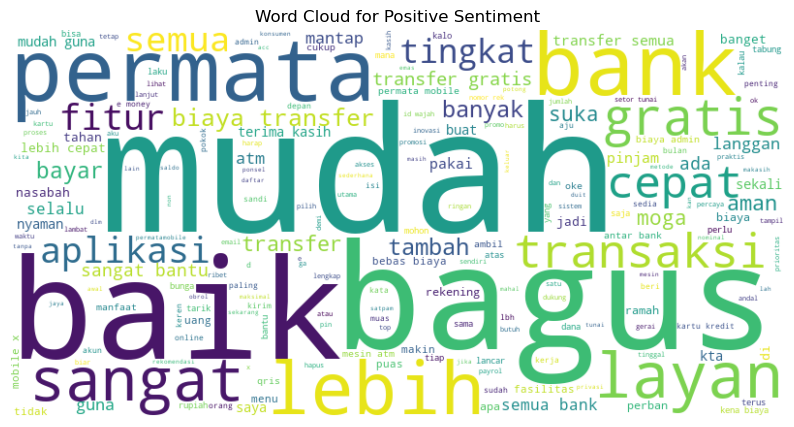

In [27]:
# Generate word clouds for positive
generate_wordcloud(df_positive, "Positive")

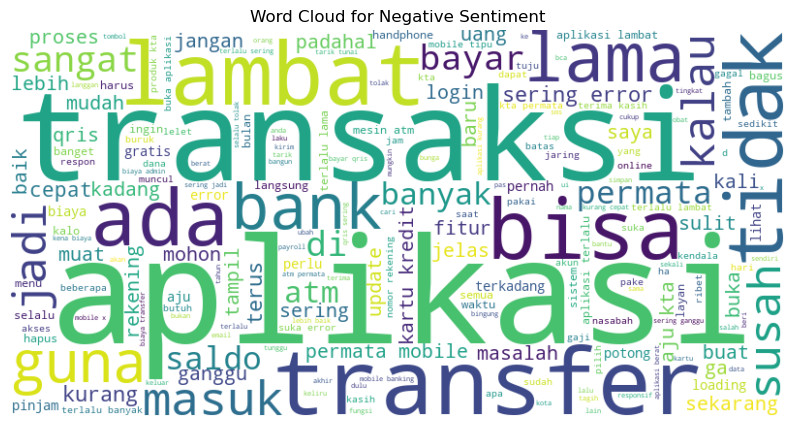

In [28]:
# Generate word clouds for negative
generate_wordcloud(df_negative, "Negative")

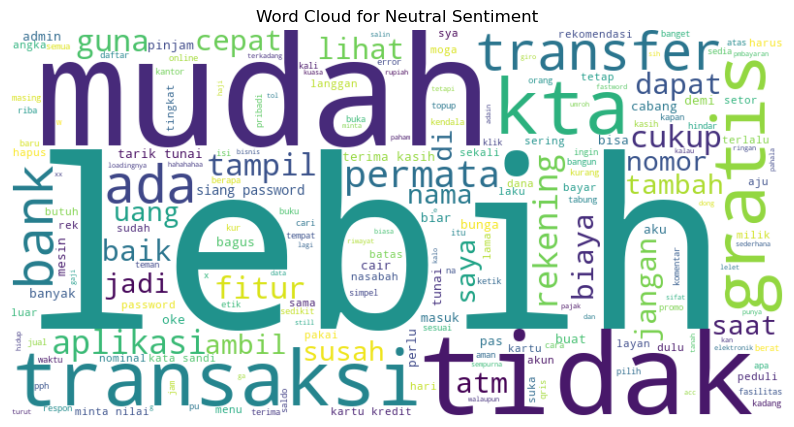

In [29]:
# Generate word clouds for neutral
generate_wordcloud(df_neutral, "Neutral")

In [30]:
def generate_wordclouds_by_theme_and_sentiment(df):
    key_themes = df['Key Theme'].unique()  # Get unique key themes
    sentiments = df['Sentiment'].unique()  # Get unique sentiments
    
    for theme in key_themes:
        for sentiment in sentiments:
            # Filter data for the current theme and sentiment
            filtered_data = df[(df['Key Theme'] == theme) & (df['Sentiment'] == sentiment)]
            
            if not filtered_data.empty:  # Proceed only if there is data for the combination
                text = " ".join(filtered_data['Feedback'].astype(str))  # Combine feedback text
                
                # Generate the WordCloud
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
                
                # Plot the WordCloud
                plt.figure(figsize=(10, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Word Cloud for {theme} ({sentiment} Sentiment)")
                plt.show()

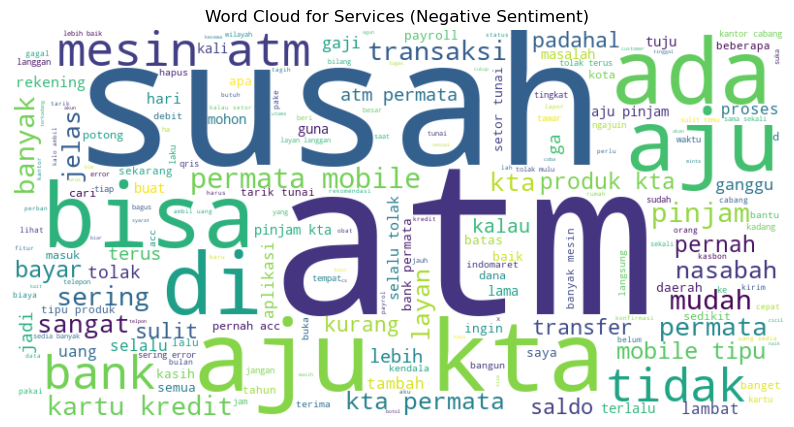

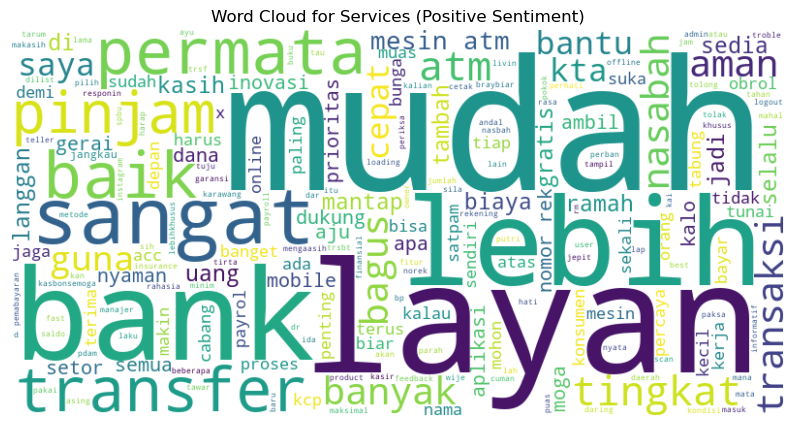

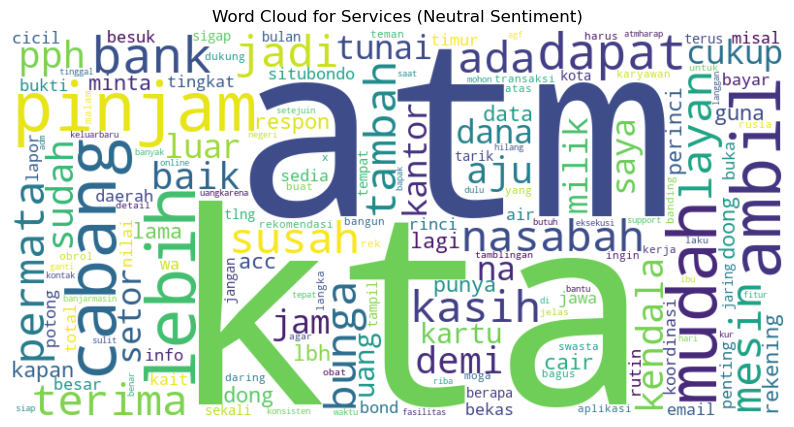

In [31]:
# Generate word clouds for Services and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_services)



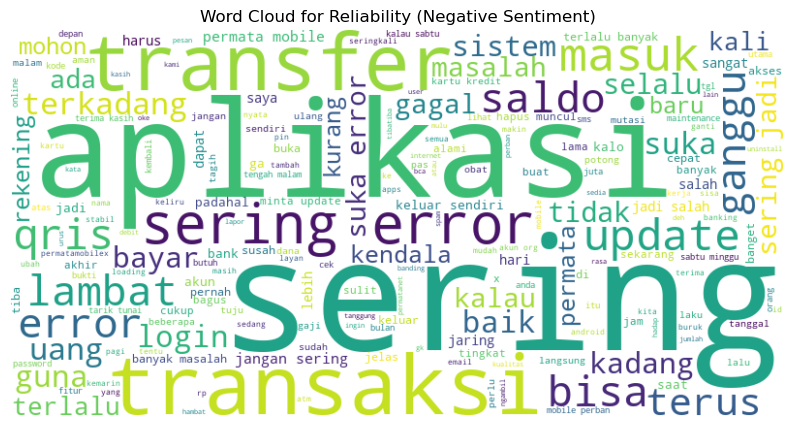

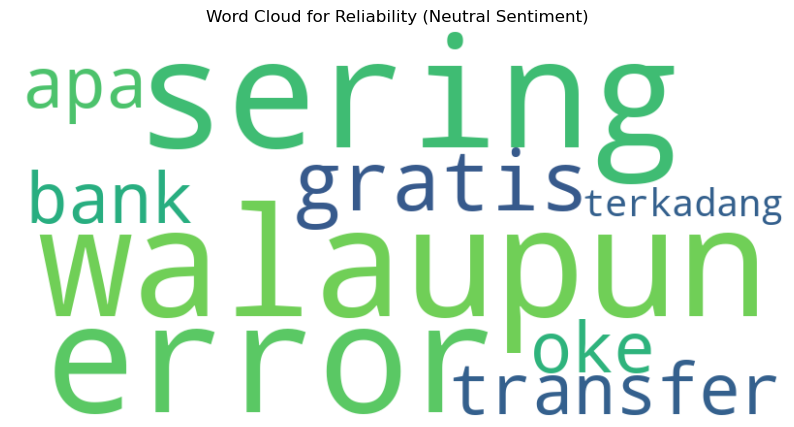

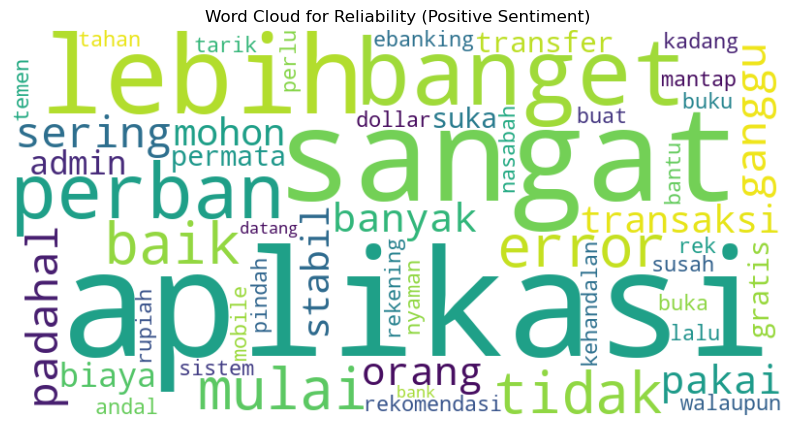

In [32]:
# Generate word clouds for Reliability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_reliability)

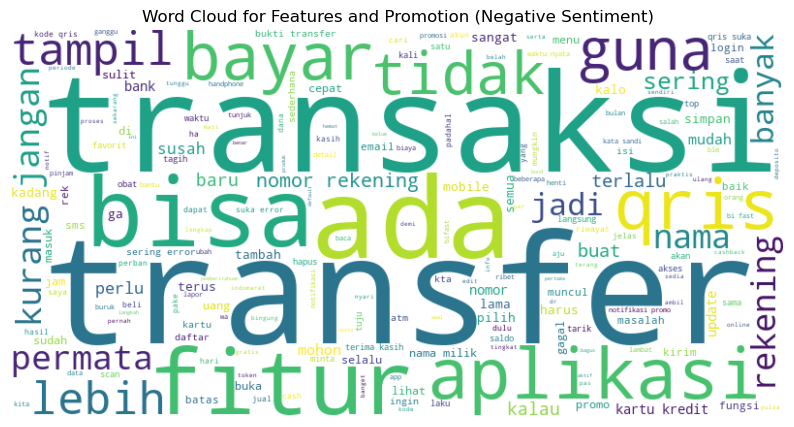

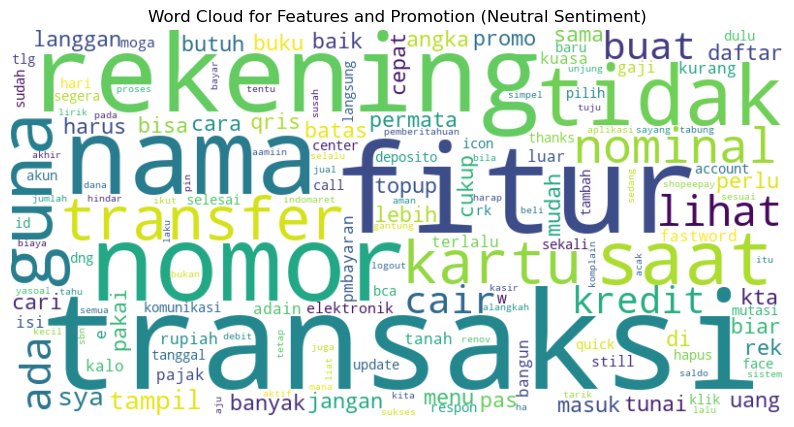

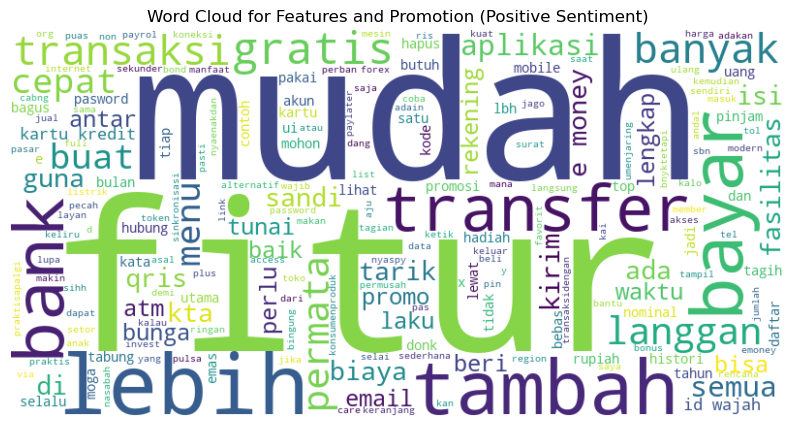

In [33]:
# Generate word clouds for Features and Promotion and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_features)

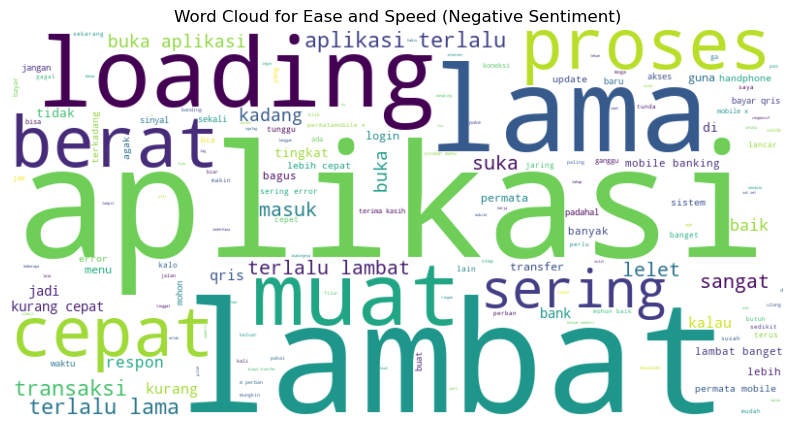

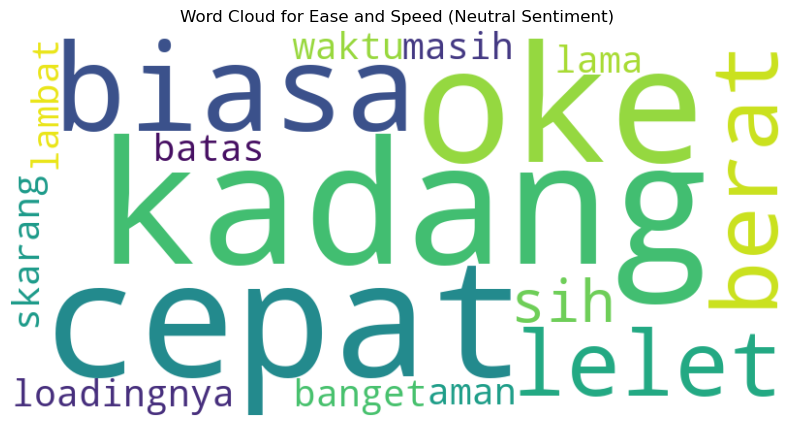

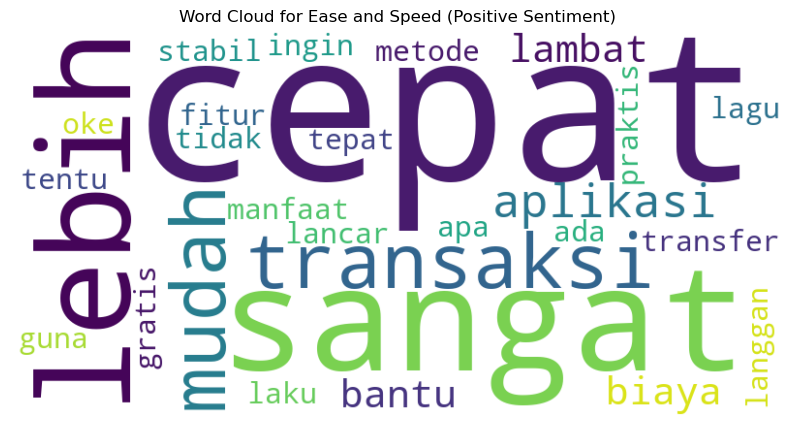

In [34]:
# Generate word clouds for Speed and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_speed)

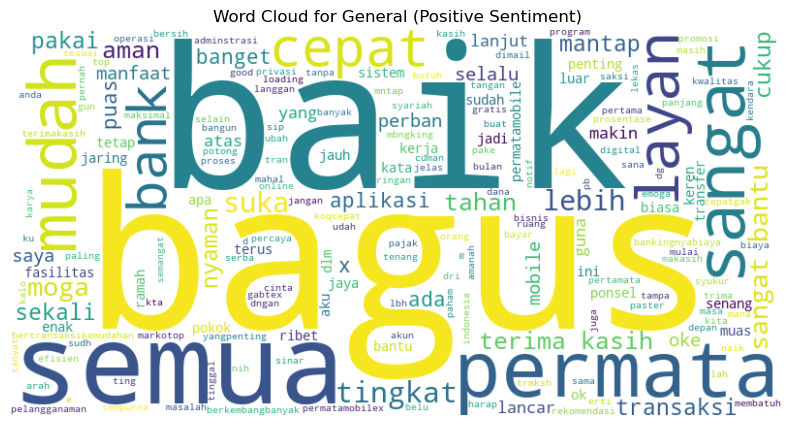

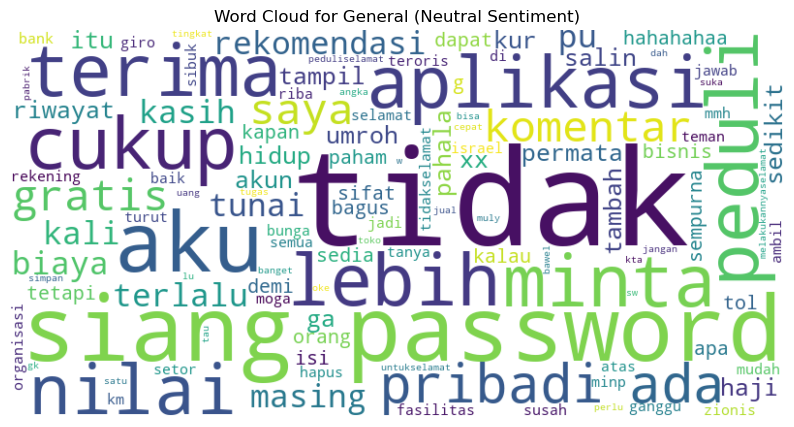

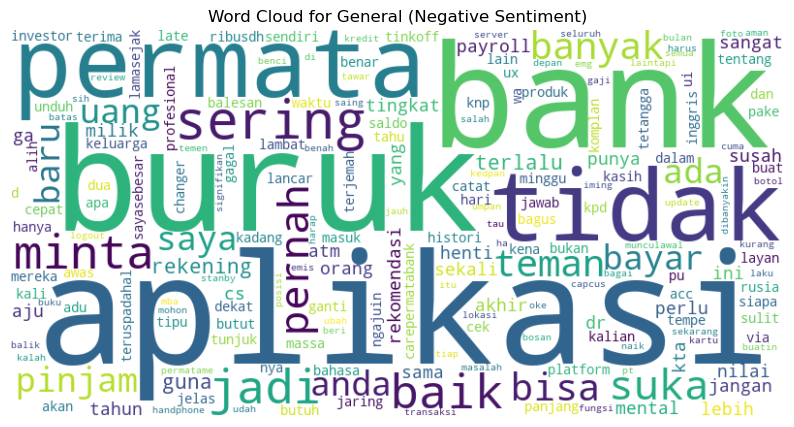

In [35]:
# Generate word clouds for General and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_general)

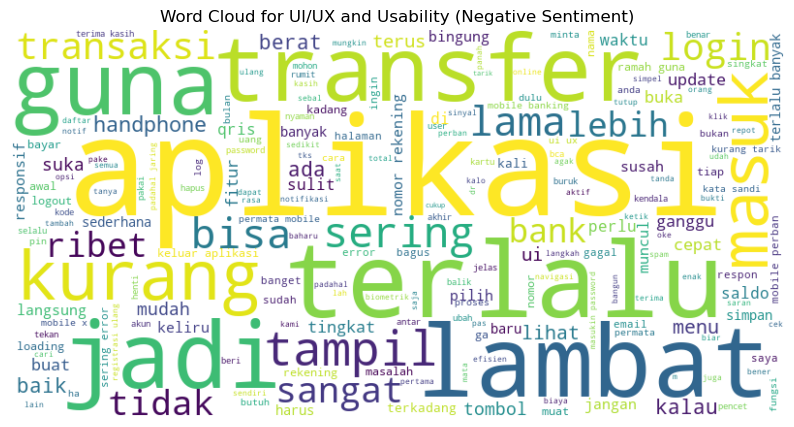

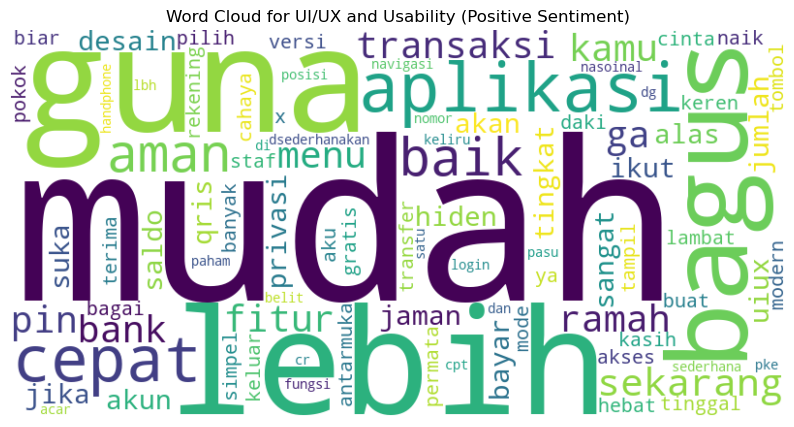

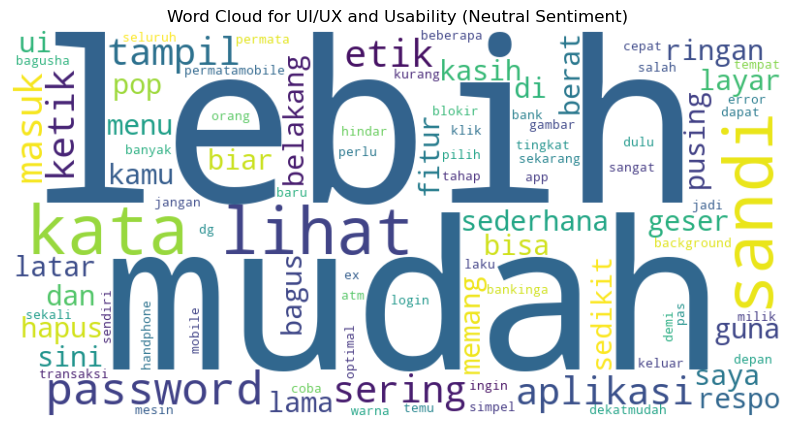

In [36]:
# Generate word clouds for UI/UX and Usability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_uiux)

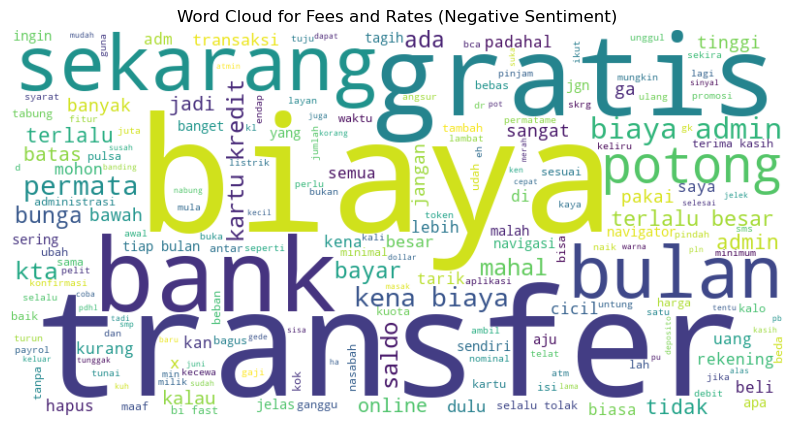

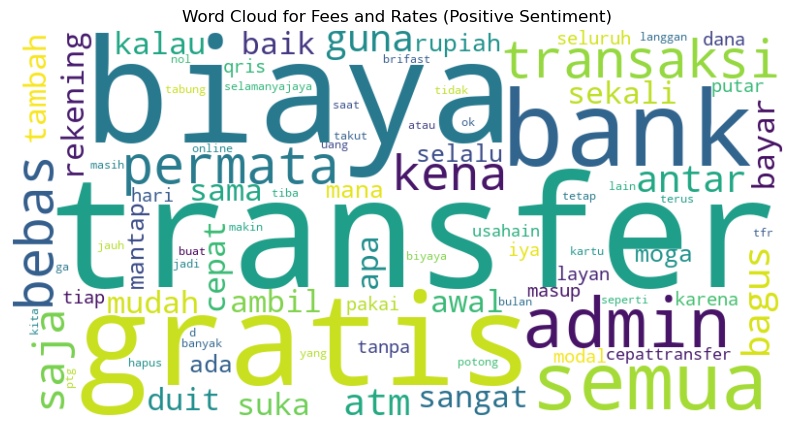

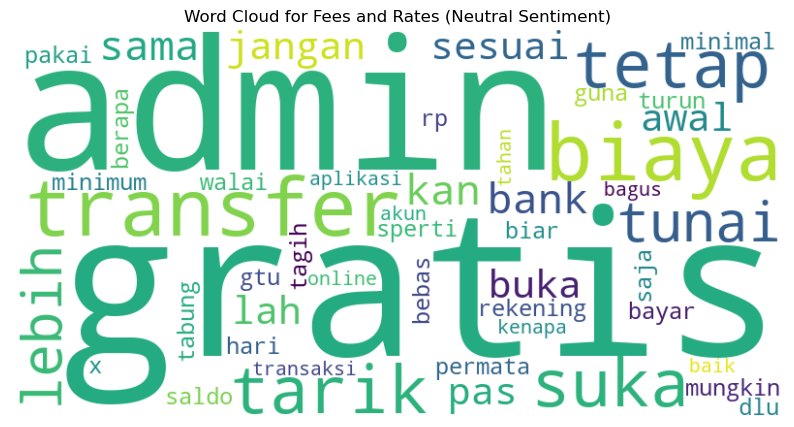

In [37]:
# Generate word clouds for Fees and Rates and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_fees)

### 5. Prepare Data Training

### 6. Training Data

In [65]:
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [93]:
y

5       Services
9       Services
11      Services
15      Services
16      Services
          ...   
2429    Services
2431    Services
2432    Services
2436    Services
2437    Services
Name: Key Theme, Length: 591, dtype: object

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming `df_stem` contains preprocessed feedback and categories
categories = df_stem['Key Theme'].unique()
resultsTV = []  # Initialize results list

for category in categories:
    print(f"Processing category: {category}")
    
    # Filter data for the current category
    df_category = df_stem.copy()
    df_category['Category_Label'] = (df_category['Key Theme'] == category).astype(int)
    
    X = df_category['Feedback']
    y = df_category['Category_Label']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Vectorize the text data
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)
    
    # Define classifiers to test
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    for clf_name, clf in classifiers.items():
        # Train the classifier
        clf.fit(X_train_smote, y_train_smote)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # Store results
        resultsTV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsTV = pd.DataFrame(resultsTV)

# Display the results
df_resultsTV

Processing category: Features and Promotion
Processing category: Reliability
Processing category: UI/UX and Usability
Processing category: Fees and Rates
Processing category: Services
Processing category: Ease and Speed
Processing category: General


Category           Classifier  Accuracy    Recall  \
0   Features and Promotion  Logistic Regression  0.809426  0.562500   
1   Features and Promotion        Random Forest  0.834016  0.325000   
2   Features and Promotion              XGBoost  0.838115  0.437500   
3              Reliability  Logistic Regression  0.868852  0.672414   
4              Reliability        Random Forest  0.891393  0.482759   
5              Reliability              XGBoost  0.885246  0.517241   
6      UI/UX and Usability  Logistic Regression  0.811475  0.629032   
7      UI/UX and Usability        Random Forest  0.875000  0.403226   
8      UI/UX and Usability              XGBoost  0.864754  0.435484   
9           Fees and Rates  Logistic Regression  0.950820  0.731707   
10          Fees and Rates        Random Forest  0.952869  0.707317   
11          Fees and Rates              XGBoost  0.946721  0.707317   
12                Services  Logistic Regression  0.877049  0.762712   
13                Services        Random Forest  0.872951  0.661017   
14                Services              XGBoost  0.848361  0.618644   
15          Ease and Speed  Logistic Regression  0.934426  0.827160   
16          Ease and Speed        Random Forest  0.930328  0.790123   
17          Ease and Speed              XGBoost  0.920082  0.777778   
18                 General  Logistic Regression  0.885246  0.617021   
19                 General        Random Forest  0.907787  0.510638   
20                 General              XGBoost  0.907787  0.510638   

    Precision  F1 Score  
0    0.436893  0.491803  
1    0.490566  0.390977  
2    0.507246  0.469799  
3    0.464286  0.549296  
4    0.549020  0.513761  
5    0.517241  0.517241  
6    0.361111  0.458824  
7    0.510204  0.450450  
8    0.465517  0.450000  
9    0.697674  0.714286  
10   0.725000  0.716049  
11   0.674419  0.690476  
12   0.737705  0.750000  
13   0.780000  0.715596  
14   0.715686  0.663636  
15   0.788235  0.807229  
16   0.790123  0.790123  
17   0.750000  0.763636  
18   0.432836  0.508772  
19   0.521739  0.516129  
20   0.521739  0.516129

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Assuming `df_stem` contains preprocessed feedback and categories
categories = df_stem['Key Theme'].unique()
resultsTVS = []  # Initialize results list

# Loop through each category
for category in categories:
    print(f"Processing category: {category}")
    
    # Filter data for the current category
    df_category = df_stem.copy()
    df_category['Category_Label'] = (df_category['Key Theme'] == category).astype(int)
    
    X = df_category['Feedback']
    y = df_category['Category_Label']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Vectorize the text data using TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Define classifiers to test
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vectorized, y_train)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # Store results
        resultsTVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsTVS = pd.DataFrame(resultsTVS)

# Display the results
df_resultsTVS


Processing category: Features and Promotion
Processing category: Reliability
Processing category: UI/UX and Usability
Processing category: Fees and Rates
Processing category: Services
Processing category: Ease and Speed
Processing category: General


Category           Classifier  Accuracy    Recall  \
0   Features and Promotion  Logistic Regression  0.850410  0.125000   
1   Features and Promotion        Random Forest  0.852459  0.187500   
2   Features and Promotion              XGBoost  0.846311  0.262500   
3              Reliability  Logistic Regression  0.879098  0.120690   
4              Reliability        Random Forest  0.887295  0.258621   
5              Reliability              XGBoost  0.891393  0.344828   
6      UI/UX and Usability  Logistic Regression  0.881148  0.112903   
7      UI/UX and Usability        Random Forest  0.870902  0.161290   
8      UI/UX and Usability              XGBoost  0.870902  0.241935   
9           Fees and Rates  Logistic Regression  0.952869  0.439024   
10          Fees and Rates        Random Forest  0.948770  0.487805   
11          Fees and Rates              XGBoost  0.946721  0.634146   
12                Services  Logistic Regression  0.866803  0.516949   
13                Services        Random Forest  0.868852  0.593220   
14                Services              XGBoost  0.864754  0.610169   
15          Ease and Speed  Logistic Regression  0.918033  0.518519   
16          Ease and Speed        Random Forest  0.932377  0.666667   
17          Ease and Speed              XGBoost  0.913934  0.617284   
18                 General  Logistic Regression  0.909836  0.106383   
19                 General        Random Forest  0.918033  0.276596   
20                 General              XGBoost  0.922131  0.382979   

    Precision  F1 Score  
0    0.769231  0.215054  
1    0.681818  0.294118  
2    0.567568  0.358974  
3    0.466667  0.191781  
4    0.555556  0.352941  
5    0.571429  0.430108  
6    0.700000  0.194444  
7    0.476190  0.240964  
8    0.483871  0.322581  
9    1.000000  0.610169  
10   0.833333  0.615385  
11   0.702703  0.666667  
12   0.884058  0.652406  
13   0.813953  0.686275  
14   0.782609  0.685714  
15   0.976744  0.677419  
16   0.900000  0.765957  
17   0.819672  0.704225  
18   0.714286  0.185185  
19   0.684211  0.393939  
20   0.666667  0.486486

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming `df_stem` contains preprocessed feedback and categories
categories = df_stem['Key Theme'].unique()
resultsCV = []  # Initialize results list

# Loop through each category
for category in categories:
    print(f"Processing category: {category}")
    
    # Filter data for the current category
    df_category = df_stem.copy()
    df_category['Category_Label'] = (df_category['Key Theme'] == category).astype(int)
    
    X = df_category['Feedback']
    y = df_category['Category_Label']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Vectorize the text data using CountVectorizer
    vectorizer = CountVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)
    
    # Define classifiers to test
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_smote, y_train_smote)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # Store results
        resultsCV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsCV = pd.DataFrame(resultsCV)

# Display the results
df_resultsCV


Processing category: Features and Promotion
Processing category: Reliability
Processing category: UI/UX and Usability
Processing category: Fees and Rates
Processing category: Services
Processing category: Ease and Speed
Processing category: General


Category           Classifier  Accuracy    Recall  \
0   Features and Promotion  Logistic Regression  0.784836  0.550000   
1   Features and Promotion        Random Forest  0.750000  0.537500   
2   Features and Promotion              XGBoost  0.856557  0.312500   
3              Reliability  Logistic Regression  0.829918  0.655172   
4              Reliability        Random Forest  0.797131  0.586207   
5              Reliability              XGBoost  0.891393  0.379310   
6      UI/UX and Usability  Logistic Regression  0.743852  0.629032   
7      UI/UX and Usability        Random Forest  0.737705  0.387097   
8      UI/UX and Usability              XGBoost  0.889344  0.306452   
9           Fees and Rates  Logistic Regression  0.918033  0.731707   
10          Fees and Rates        Random Forest  0.887295  0.756098   
11          Fees and Rates              XGBoost  0.950820  0.682927   
12                Services  Logistic Regression  0.807377  0.694915   
13                Services        Random Forest  0.750000  0.703390   
14                Services              XGBoost  0.866803  0.644068   
15          Ease and Speed  Logistic Regression  0.899590  0.802469   
16          Ease and Speed        Random Forest  0.868852  0.864198   
17          Ease and Speed              XGBoost  0.936475  0.814815   
18                 General  Logistic Regression  0.870902  0.787234   
19                 General        Random Forest  0.877049  0.765957   
20                 General              XGBoost  0.922131  0.446809   

    Precision  F1 Score  
0    0.389381  0.455959  
1    0.335938  0.413462  
2    0.625000  0.416667  
3    0.376238  0.477987  
4    0.311927  0.407186  
5    0.564103  0.453608  
6    0.276596  0.384236  
7    0.210526  0.272727  
8    0.633333  0.413043  
9    0.508475  0.600000  
10   0.407895  0.529915  
11   0.717949  0.700000  
12   0.585714  0.635659  
13   0.488235  0.576389  
14   0.767677  0.700461  
15   0.663265  0.726257  
16   0.569106  0.686275  
17   0.804878  0.809816  
18   0.411111  0.540146  
19   0.423529  0.545455  
20   0.636364  0.525000

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Assuming `df_stem` contains preprocessed feedback and categories
categories = df_stem['Key Theme'].unique()
resultsCVS = []  # Initialize results list

# Loop through each category
for category in categories:
    print(f"Processing category: {category}")
    
    # Filter data for the current category
    df_category = df_stem.copy()
    df_category['Category_Label'] = (df_category['Key Theme'] == category).astype(int)
    
    X = df_category['Feedback']
    y = df_category['Category_Label']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Vectorize the text data using CountVectorizer
    vectorizer = CountVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Define classifiers to test
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vectorized, y_train)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # Store results
        resultsCVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsCVS = pd.DataFrame(resultsCVS)

# Display the results
df_resultsCVS


Processing category: Features and Promotion
Processing category: Reliability
Processing category: UI/UX and Usability
Processing category: Fees and Rates
Processing category: Services
Processing category: Ease and Speed
Processing category: General


Category           Classifier  Accuracy    Recall  \
0   Features and Promotion  Logistic Regression  0.864754  0.337500   
1   Features and Promotion        Random Forest  0.848361  0.237500   
2   Features and Promotion              XGBoost  0.856557  0.275000   
3              Reliability  Logistic Regression  0.893443  0.362069   
4              Reliability        Random Forest  0.879098  0.241379   
5              Reliability              XGBoost  0.889344  0.327586   
6      UI/UX and Usability  Logistic Regression  0.897541  0.354839   
7      UI/UX and Usability        Random Forest  0.879098  0.258065   
8      UI/UX and Usability              XGBoost  0.883197  0.258065   
9           Fees and Rates  Logistic Regression  0.954918  0.609756   
10          Fees and Rates        Random Forest  0.944672  0.609756   
11          Fees and Rates              XGBoost  0.954918  0.658537   
12                Services  Logistic Regression  0.877049  0.644068   
13                Services        Random Forest  0.875000  0.635593   
14                Services              XGBoost  0.877049  0.677966   
15          Ease and Speed  Logistic Regression  0.934426  0.679012   
16          Ease and Speed        Random Forest  0.936475  0.777778   
17          Ease and Speed              XGBoost  0.926230  0.728395   
18                 General  Logistic Regression  0.922131  0.340426   
19                 General        Random Forest  0.922131  0.489362   
20                 General              XGBoost  0.928279  0.468085   

    Precision  F1 Score  
0    0.675000  0.450000  
1    0.593750  0.339286  
2    0.647059  0.385965  
3    0.583333  0.446809  
4    0.482759  0.321839  
5    0.558824  0.413043  
6    0.687500  0.468085  
7    0.551724  0.351648  
8    0.592593  0.359551  
9    0.806452  0.694444  
10   0.694444  0.649351  
11   0.771429  0.710526  
12   0.808511  0.716981  
13   0.806452  0.710900  
14   0.784314  0.727273  
15   0.901639  0.774648  
16   0.828947  0.802548  
17   0.808219  0.766234  
18   0.695652  0.457143  
19   0.621622  0.547619  
20   0.687500  0.556962

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pandas as pd

resultsCV = []

for category in df_stem['Key Theme'].unique():
    # Filter feedback related to the current category
    df_category = df_stem[df_stem['Key Theme'] == category]
    X = df_stem['Feedback'] 
    y = df_stem['Key Theme'] 
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Vectorize the text data
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()
    
    # Define classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(kernel='linear')
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vectorized, y_train)
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # Append results
        resultsCV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsCV = pd.DataFrame(resultsCV)
df_resultsCV



ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pandas as pd

resultsTV = []

for category in df_stem['Key Theme'].unique():
    # Filter feedback related to the current category
    df_category = df_stem[df_stem['Key Theme'] == category]
    X = df_stem['Feedback']
    y = df_stem['Key Theme']
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Vectorize the text data using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Define classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(kernel='linear')
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vectorized, y_train)
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results
        resultsTV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsTV = pd.DataFrame(resultsTV)
df_resultsTV


Category     Classifier  Accuracy    Recall  Precision  \
0   Features and Promotion            KNN  0.536885  0.536885   0.544174   
1   Features and Promotion  Random Forest  0.590164  0.590164   0.587783   
2   Features and Promotion    Naive Bayes  0.567623  0.567623   0.642144   
3   Features and Promotion            SVM  0.600410  0.600410   0.611042   
4              Reliability            KNN  0.536885  0.536885   0.544174   
5              Reliability  Random Forest  0.594262  0.594262   0.594242   
6              Reliability    Naive Bayes  0.567623  0.567623   0.642144   
7              Reliability            SVM  0.600410  0.600410   0.611042   
8      UI/UX and Usability            KNN  0.536885  0.536885   0.544174   
9      UI/UX and Usability  Random Forest  0.602459  0.602459   0.602106   
10     UI/UX and Usability    Naive Bayes  0.567623  0.567623   0.642144   
11     UI/UX and Usability            SVM  0.600410  0.600410   0.611042   
12          Fees and Rates            KNN  0.536885  0.536885   0.544174   
13          Fees and Rates  Random Forest  0.598361  0.598361   0.598005   
14          Fees and Rates    Naive Bayes  0.567623  0.567623   0.642144   
15          Fees and Rates            SVM  0.600410  0.600410   0.611042   
16                Services            KNN  0.536885  0.536885   0.544174   
17                Services  Random Forest  0.573770  0.573770   0.572703   
18                Services    Naive Bayes  0.567623  0.567623   0.642144   
19                Services            SVM  0.600410  0.600410   0.611042   
20          Ease and Speed            KNN  0.536885  0.536885   0.544174   
21          Ease and Speed  Random Forest  0.594262  0.594262   0.593557   
22          Ease and Speed    Naive Bayes  0.567623  0.567623   0.642144   
23          Ease and Speed            SVM  0.600410  0.600410   0.611042   
24                 General            KNN  0.536885  0.536885   0.544174   
25                 General  Random Forest  0.586066  0.586066   0.581361   
26                 General    Naive Bayes  0.567623  0.567623   0.642144   
27                 General            SVM  0.600410  0.600410   0.611042   

    F1 Score  
0   0.528830  
1   0.583178  
2   0.525209  
3   0.599570  
4   0.528830  
5   0.587253  
6   0.525209  
7   0.599570  
8   0.528830  
9   0.594965  
10  0.525209  
11  0.599570  
12  0.528830  
13  0.592126  
14  0.525209  
15  0.599570  
16  0.528830  
17  0.564271  
18  0.525209  
19  0.599570  
20  0.528830  
21  0.587579  
22  0.525209  
23  0.599570  
24  0.528830  
25  0.578178  
26  0.525209  
27  0.599570

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pandas as pd

resultsCV = []

for category in df_stem['Key Theme'].unique():
    # Filter feedback related to the current category
    df_category = df_stem[df_stem['Key Theme'] == category]
    X = df_stem['Feedback']
    y = df_stem['Key Theme']
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Vectorize the text data
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)
    
    # Define classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(kernel='linear')
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_smote, y_train_smote)
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results
        resultsCV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsCV = pd.DataFrame(resultsCV)
df_resultsCV


Category     Classifier  Accuracy    Recall  Precision  \
0   Features and Promotion            KNN  0.463115  0.463115   0.562945   
1   Features and Promotion  Random Forest  0.536885  0.536885   0.568218   
2   Features and Promotion    Naive Bayes  0.606557  0.606557   0.619857   
3   Features and Promotion            SVM  0.565574  0.565574   0.571078   
4              Reliability            KNN  0.463115  0.463115   0.562945   
5              Reliability  Random Forest  0.555328  0.555328   0.584678   
6              Reliability    Naive Bayes  0.606557  0.606557   0.619857   
7              Reliability            SVM  0.565574  0.565574   0.571078   
8      UI/UX and Usability            KNN  0.463115  0.463115   0.562945   
9      UI/UX and Usability  Random Forest  0.561475  0.561475   0.592905   
10     UI/UX and Usability    Naive Bayes  0.606557  0.606557   0.619857   
11     UI/UX and Usability            SVM  0.565574  0.565574   0.571078   
12          Fees and Rates            KNN  0.463115  0.463115   0.562945   
13          Fees and Rates  Random Forest  0.551230  0.551230   0.586736   
14          Fees and Rates    Naive Bayes  0.606557  0.606557   0.619857   
15          Fees and Rates            SVM  0.565574  0.565574   0.571078   
16                Services            KNN  0.463115  0.463115   0.562945   
17                Services  Random Forest  0.559426  0.559426   0.588010   
18                Services    Naive Bayes  0.606557  0.606557   0.619857   
19                Services            SVM  0.565574  0.565574   0.571078   
20          Ease and Speed            KNN  0.463115  0.463115   0.562945   
21          Ease and Speed  Random Forest  0.557377  0.557377   0.582811   
22          Ease and Speed    Naive Bayes  0.606557  0.606557   0.619857   
23          Ease and Speed            SVM  0.565574  0.565574   0.571078   
24                 General            KNN  0.463115  0.463115   0.562945   
25                 General  Random Forest  0.538934  0.538934   0.571231   
26                 General    Naive Bayes  0.606557  0.606557   0.619857   
27                 General            SVM  0.565574  0.565574   0.571078   

    F1 Score  
0   0.459432  
1   0.534821  
2   0.608272  
3   0.564118  
4   0.459432  
5   0.554192  
6   0.608272  
7   0.564118  
8   0.459432  
9   0.562033  
10  0.608272  
11  0.564118  
12  0.459432  
13  0.550286  
14  0.608272  
15  0.564118  
16  0.459432  
17  0.559627  
18  0.608272  
19  0.564118  
20  0.459432  
21  0.554889  
22  0.608272  
23  0.564118  
24  0.459432  
25  0.537291  
26  0.608272  
27  0.564118

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pandas as pd

# Initialize results list
resultsTV2 = []

for category in df_stem['Key Theme'].unique():
    # Filter feedback related to the current category
    df_category = df_stem[df_stem['Key Theme'] == category]
    X = df_stem['Feedback']
    y = df_stem['Key Theme']
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Vectorize the text data
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)
    
    # Define classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(kernel='linear', random_state=42)
    }
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_smote, y_train_smote)
        y_pred = clf.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results
        resultsTV2.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

# Convert results to a DataFrame
df_resultsTV2 = pd.DataFrame(resultsTV2)
df_resultsTV2


Category     Classifier  Accuracy    Recall  Precision  \
0   Features and Promotion            KNN  0.530738  0.530738   0.592196   
1   Features and Promotion  Random Forest  0.631148  0.631148   0.631826   
2   Features and Promotion    Naive Bayes  0.653689  0.653689   0.669448   
3   Features and Promotion            SVM  0.647541  0.647541   0.664407   
4              Reliability            KNN  0.530738  0.530738   0.592196   
5              Reliability  Random Forest  0.631148  0.631148   0.631826   
6              Reliability    Naive Bayes  0.653689  0.653689   0.669448   
7              Reliability            SVM  0.647541  0.647541   0.664407   
8      UI/UX and Usability            KNN  0.530738  0.530738   0.592196   
9      UI/UX and Usability  Random Forest  0.631148  0.631148   0.631826   
10     UI/UX and Usability    Naive Bayes  0.653689  0.653689   0.669448   
11     UI/UX and Usability            SVM  0.647541  0.647541   0.664407   
12          Fees and Rates            KNN  0.530738  0.530738   0.592196   
13          Fees and Rates  Random Forest  0.631148  0.631148   0.631826   
14          Fees and Rates    Naive Bayes  0.653689  0.653689   0.669448   
15          Fees and Rates            SVM  0.647541  0.647541   0.664407   
16                Services            KNN  0.530738  0.530738   0.592196   
17                Services  Random Forest  0.631148  0.631148   0.631826   
18                Services    Naive Bayes  0.653689  0.653689   0.669448   
19                Services            SVM  0.647541  0.647541   0.664407   
20          Ease and Speed            KNN  0.530738  0.530738   0.592196   
21          Ease and Speed  Random Forest  0.631148  0.631148   0.631826   
22          Ease and Speed    Naive Bayes  0.653689  0.653689   0.669448   
23          Ease and Speed            SVM  0.647541  0.647541   0.664407   
24                 General            KNN  0.530738  0.530738   0.592196   
25                 General  Random Forest  0.631148  0.631148   0.631826   
26                 General    Naive Bayes  0.653689  0.653689   0.669448   
27                 General            SVM  0.647541  0.647541   0.664407   

    F1 Score  
0   0.533350  
1   0.627735  
2   0.657412  
3   0.651822  
4   0.533350  
5   0.627735  
6   0.657412  
7   0.651822  
8   0.533350  
9   0.627735  
10  0.657412  
11  0.651822  
12  0.533350  
13  0.627735  
14  0.657412  
15  0.651822  
16  0.533350  
17  0.627735  
18  0.657412  
19  0.651822  
20  0.533350  
21  0.627735  
22  0.657412  
23  0.651822  
24  0.533350  
25  0.627735  
26  0.657412  
27  0.651822

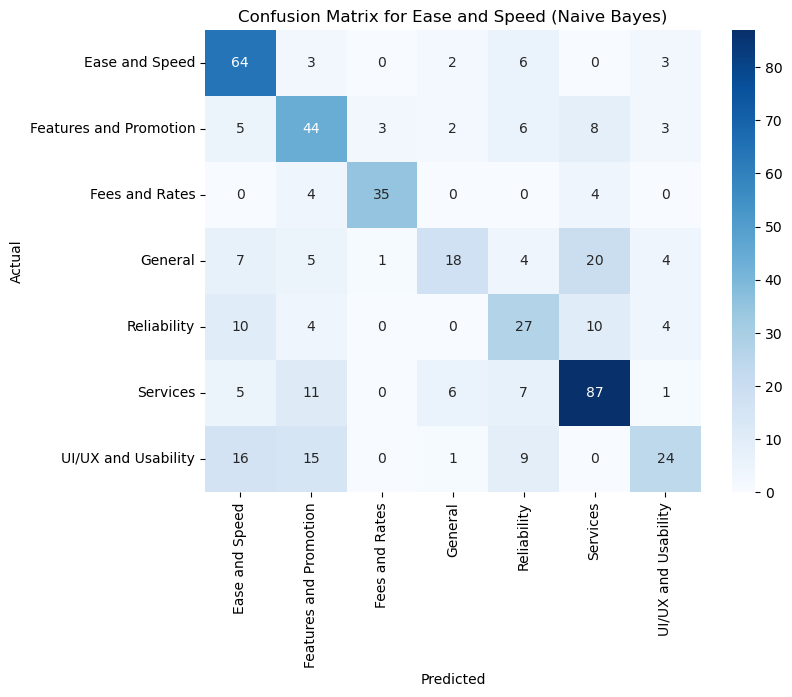

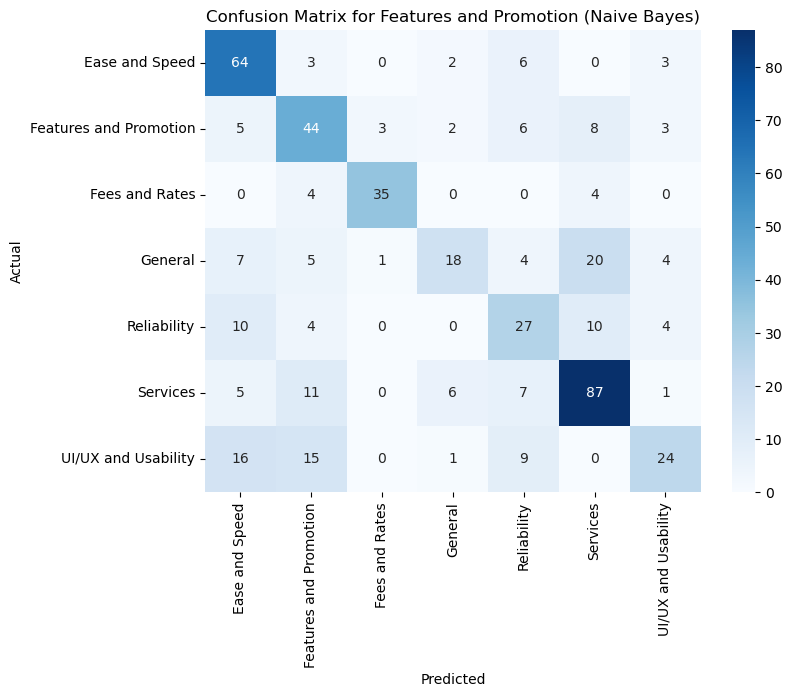

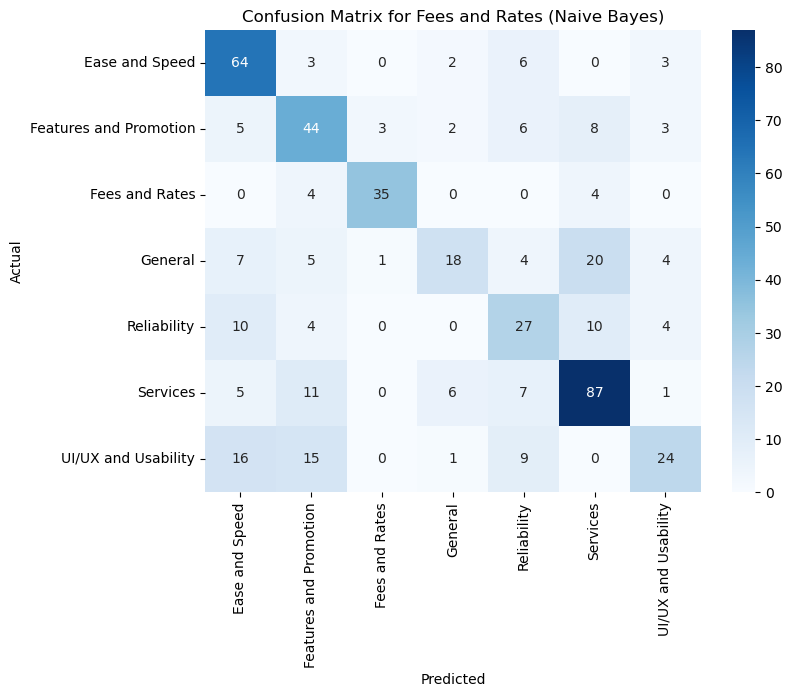

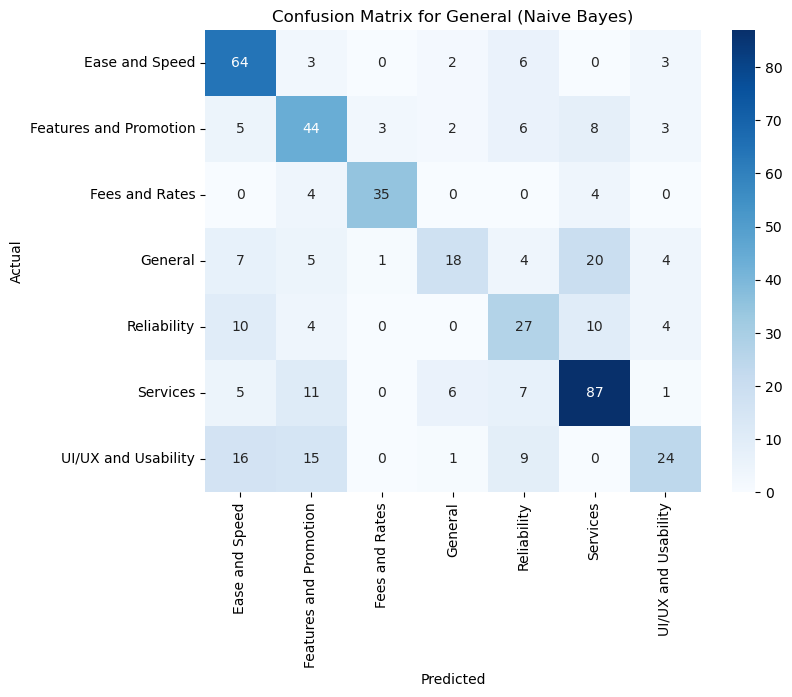

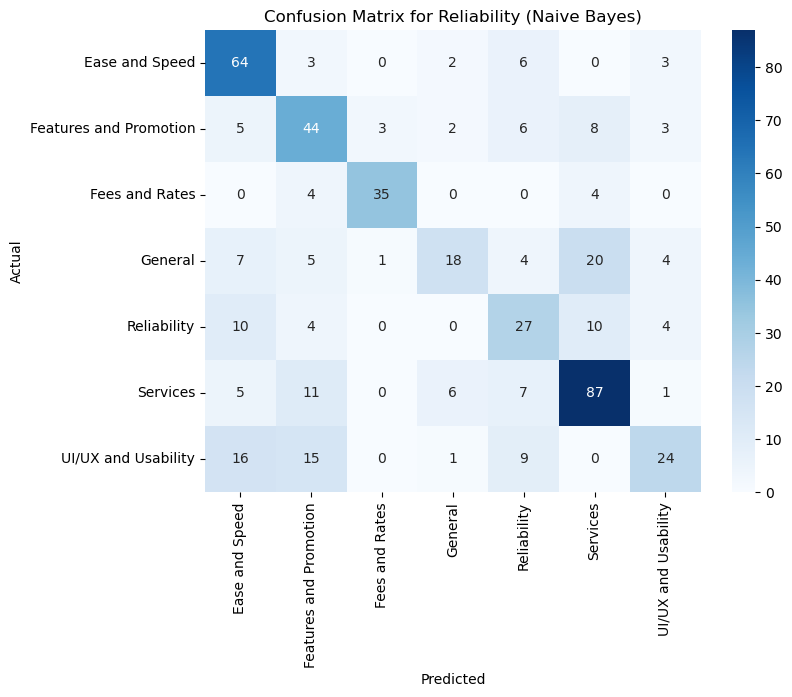

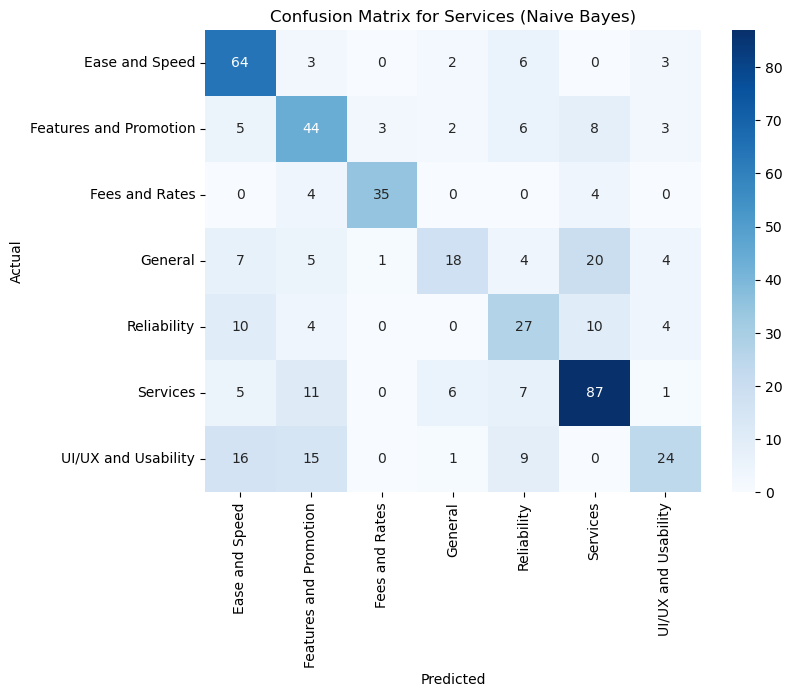

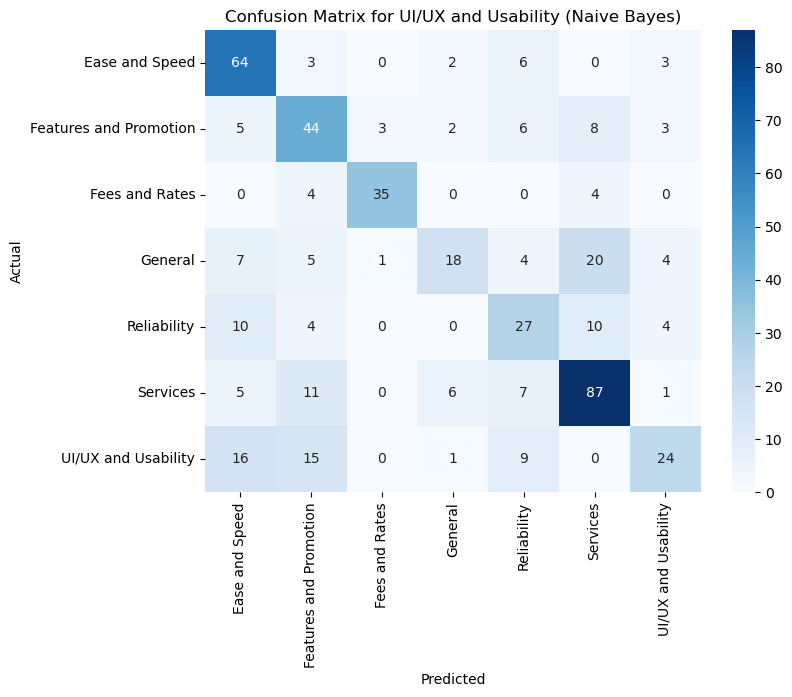

In [41]:
# Confusion Matrix Tfidf
from sklearn.metrics import confusion_matrix

best_classifiers = df_resultsTV2.loc[df_resultsTV2.groupby('Category')['Accuracy'].idxmax()]

for index, row in best_classifiers.iterrows():
    category = row['Category']
    clf_name = row['Classifier']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()

    clf = classifiers[clf_name]
    clf.fit(X_train_vectorized, y_train)
    y_pred = clf.predict(X_test_vectorized)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))

    plt.title(f"Confusion Matrix for {category} ({clf_name})")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



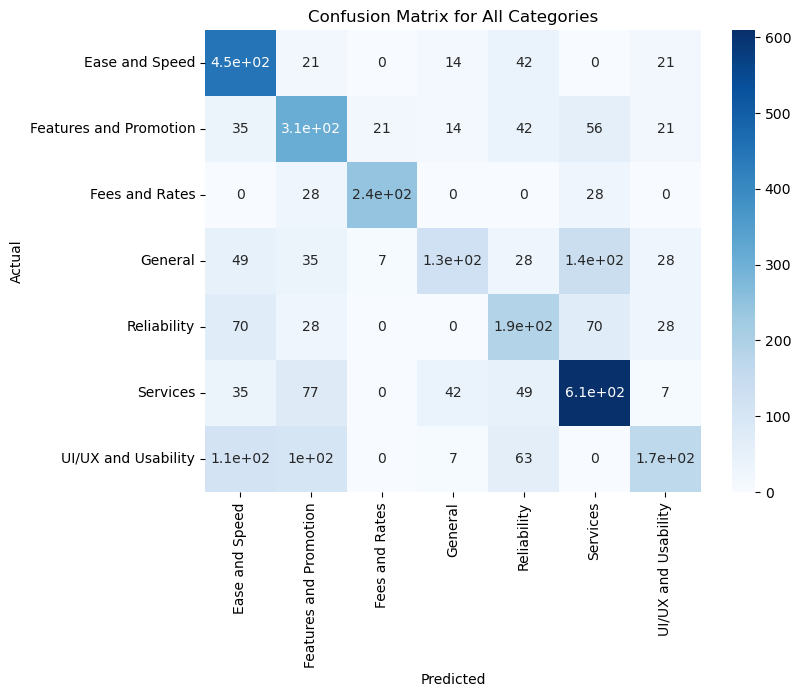

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming df_resultsTV2 and classifiers are already defined
best_classifiers = df_resultsTV2.loc[df_resultsTV2.groupby('Category')['Accuracy'].idxmax()]

# Initialize lists to store actual and predicted values
y_true = []
y_pred = []

# Loop through the best classifiers and accumulate predictions
for index, row in best_classifiers.iterrows():
    category = row['Category']
    clf_name = row['Classifier']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()

    clf = classifiers[clf_name]
    clf.fit(X_train_vectorized, y_train)
    y_pred_category = clf.predict(X_test_vectorized)

    # Append the actual and predicted values for the current category
    y_true.extend(y_test)
    y_pred.extend(y_pred_category)

# Compute the confusion matrix for all categories combined
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))

plt.title("Confusion Matrix for All Categories")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 7. Testing